# 10y Bond Forecasting with LSTMs

In [36]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
from keras import backend as K
import tensorflow as tf
from tensorflow.python.client import device_lib
from bokeh.io import output_notebook
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction, plot_model_history, save_model, mean_absolute_percentage_error)
#import h5py

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

output_notebook()

OS:  linux
Python:  3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
Keras:  2.1.5
Tensorflow:  1.4.0
Numpy:  1.14.2
Number of CPU processors:  4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [37]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10092397945439710532
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 233570304
locality {
  bus_id: 1
}
incarnation: 7816086146933498880
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [38]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Data

In [39]:
VERSION = '01.4'

In [40]:
DATA = os.path.join('data', 'test_bond.csv')
SAVE_DIR = 'models'
EPOCHS = 200
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 64
UNITS = 100
OPT = 'adam'

In [41]:
df_bond = pd.read_csv(DATA)

In [42]:
print(df_bond.shape)

(14362, 2)


In [43]:
df_bond.head()

,date,10Y Bond
0,2018-03-01,2.848
1,2018-02-28,2.864
2,2018-02-27,2.901
3,2018-02-26,2.864
4,2018-02-25,2.875


In [44]:
df_bond.tail()

,date,10Y Bond
14357,1952-12-31,2.68
14358,1951-12-31,2.57
14359,1950-12-29,2.32
14360,1949-12-30,2.47
14361,1948-12-31,2.49


In [45]:
df_bond['datetime'] = pd.to_datetime(df_bond.date)

In [46]:
df_bond.sort_values(by='datetime', ascending=True, inplace=True)

In [47]:
df_bond.head()

,date,10Y Bond,datetime
14361,1948-12-31,2.49,1948-12-31
14360,1949-12-30,2.47,1949-12-30
14359,1950-12-29,2.32,1950-12-29
14358,1951-12-31,2.57,1951-12-31
14357,1952-12-31,2.68,1952-12-31


In [48]:
df_bond.tail()

,date,10Y Bond,datetime
4,2018-02-25,2.875,2018-02-25
3,2018-02-26,2.864,2018-02-26
2,2018-02-27,2.901,2018-02-27
1,2018-02-28,2.864,2018-02-28
0,2018-03-01,2.848,2018-03-01


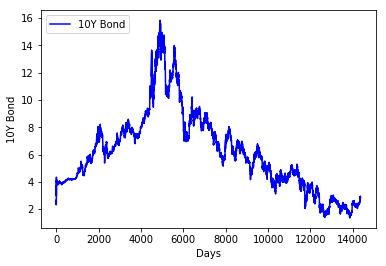

In [49]:
bond = df_bond['10Y Bond']
plot_series(bond, xlabel='Days', ylabel='10Y Bond', color='b', legend='10Y Bond')

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
bond = scaler.fit_transform(np.reshape(bond, (len(bond),1)))

/home/temenid/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [51]:
train, test = train_test_split(bond, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(10053, 1)
(4309, 1)


In [52]:
test[:-5]

array([[0.26964508],
       [0.265502  ],
       [0.2679188 ],
       ...,
       [0.11006767],
       [0.10778898],
       [0.10412926]])

In [53]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10051, 1, 1) (10051,)
(4307, 1, 1) (4307,)


### LSTM

In [54]:
model_name = 'keras_' + 'lstm' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION + 'trained_model.h5'

In [55]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(units, input_shape=(1, time_ahead)))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(1, time_ahead)))
    elif model_name == 'GRU':
        model.add(GRU(units, input_shape=(1, time_ahead)))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

In [56]:
lstm_model = create_symbol(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
lstm_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [57]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0447 - acc: 9.9493e-05
Epoch 2/200
 - 1s - loss: 0.0060 - acc: 9.9493e-05
Epoch 3/200
 - 1s - loss: 9.3748e-04 - acc: 9.9493e-05
Epoch 4/200
 - 1s - loss: 7.4527e-05 - acc: 9.9493e-05
Epoch 5/200
 - 1s - loss: 6.4237e-05 - acc: 9.9493e-05
Epoch 6/200
 - 1s - loss: 6.1681e-05 - acc: 9.9493e-05
Epoch 7/200
 - 1s - loss: 5.9250e-05 - acc: 9.9493e-05
Epoch 8/200
 - 1s - loss: 5.6250e-05 - acc: 9.9493e-05
Epoch 9/200
 - 1s - loss: 5.3549e-05 - acc: 9.9493e-05
Epoch 10/200
 - 1s - loss: 5.0881e-05 - acc: 9.9493e-05
Epoch 11/200
 - 1s - loss: 4.8207e-05 - acc: 9.9493e-05
Epoch 12/200
 - 1s - loss: 4.5255e-05 - acc: 9.9493e-05
Epoch 13/200
 - 1s - loss: 4.2573e-05 - acc: 9.9493e-05
Epoch 14/200
 - 1s - loss: 4.0406e-05 - acc: 9.9493e-05
Epoch 15/200
 - 1s - loss: 3.8152e-05 - acc: 9.9493e-05
Epoch 16/200
 - 1s - loss: 3.5510e-05 - acc: 9.9493e-05
Epoch 17/200
 - 1s - loss: 3.3747e-05 - acc: 9.9493e-05
Epoch 18/200
 - 1s - loss: 3.1814e-05 - acc: 9.9493e-05
Epoch 19/

Epoch 147/200
 - 1s - loss: 2.6967e-05 - acc: 9.9493e-05
Epoch 148/200
 - 1s - loss: 2.6848e-05 - acc: 9.9493e-05
Epoch 149/200
 - 1s - loss: 2.9806e-05 - acc: 9.9493e-05
Epoch 150/200
 - 1s - loss: 2.9411e-05 - acc: 9.9493e-05
Epoch 151/200
 - 1s - loss: 2.7377e-05 - acc: 9.9493e-05
Epoch 152/200
 - 1s - loss: 2.8762e-05 - acc: 9.9493e-05
Epoch 153/200
 - 1s - loss: 2.8612e-05 - acc: 9.9493e-05
Epoch 154/200
 - 1s - loss: 2.8033e-05 - acc: 9.9493e-05
Epoch 155/200
 - 1s - loss: 2.9599e-05 - acc: 9.9493e-05
Epoch 156/200
 - 1s - loss: 2.7458e-05 - acc: 9.9493e-05
Epoch 157/200
 - 1s - loss: 2.7945e-05 - acc: 9.9493e-05
Epoch 158/200
 - 1s - loss: 2.6908e-05 - acc: 9.9493e-05
Epoch 159/200
 - 1s - loss: 2.7489e-05 - acc: 9.9493e-05
Epoch 160/200
 - 1s - loss: 2.7145e-05 - acc: 9.9493e-05
Epoch 161/200
 - 1s - loss: 2.7217e-05 - acc: 9.9493e-05
Epoch 162/200
 - 1s - loss: 2.7659e-05 - acc: 9.9493e-05
Epoch 163/200
 - 1s - loss: 2.8987e-05 - acc: 9.9493e-05
Epoch 164/200
 - 1s - loss: 2.7

In [58]:
#lstm_history.history

In [59]:
# plot model history
#plot_model_history(lstm_history)

`pred_test` will have a shape of `(num_rows, TIME_AHEAD)`, having the predicted values for the next `TIME_AHEAD` days.

In [60]:
y_test_inv = scaler.inverse_transform([y_test])
bond_inv = scaler.inverse_transform(bond)

In [63]:
pred_test = lstm_model.predict(X_test) #pred_test.shape = (num_rows, TIME_AHEAD)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.080


In [64]:
pred_test[:,0]

array([5.292115 , 5.232455 , 5.2672553, ..., 2.9288416, 2.91802  ,
       2.954423 ], dtype=float32)

In [65]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 2.453


In [66]:
save_model(lstm_model, SAVE_DIR, model_name)

Saved trained model at models/keras_lstm_units_100_opt_adam_v01.4trained_model.h5 


In [67]:
pred_train = lstm_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='LSTM_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])

### BiLSTM
Now we can try with a Bi-directional LSTM (BiLSTM).

In [68]:
model_name = 'keras_' + 'BiLSTM' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION + '_' + 'trained_model.h5'

In [69]:
bilstm_model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
bilstm_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [70]:
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0329 - acc: 9.9493e-05
Epoch 2/200
 - 1s - loss: 0.0027 - acc: 9.9493e-05
Epoch 3/200
 - 1s - loss: 1.3235e-04 - acc: 9.9493e-05
Epoch 4/200
 - 1s - loss: 4.4397e-05 - acc: 9.9493e-05
Epoch 5/200
 - 1s - loss: 4.3434e-05 - acc: 9.9493e-05
Epoch 6/200
 - 1s - loss: 4.2247e-05 - acc: 9.9493e-05
Epoch 7/200
 - 1s - loss: 4.1338e-05 - acc: 9.9493e-05
Epoch 8/200
 - 1s - loss: 4.0451e-05 - acc: 9.9493e-05
Epoch 9/200
 - 1s - loss: 3.8625e-05 - acc: 9.9493e-05
Epoch 10/200
 - 1s - loss: 3.7288e-05 - acc: 9.9493e-05
Epoch 11/200
 - 1s - loss: 3.6208e-05 - acc: 9.9493e-05
Epoch 12/200
 - 1s - loss: 3.4759e-05 - acc: 9.9493e-05
Epoch 13/200
 - 1s - loss: 3.3639e-05 - acc: 9.9493e-05
Epoch 14/200
 - 1s - loss: 3.2760e-05 - acc: 9.9493e-05
Epoch 15/200
 - 1s - loss: 3.1487e-05 - acc: 9.9493e-05
Epoch 16/200
 - 1s - loss: 3.0581e-05 - acc: 9.9493e-05
Epoch 17/200
 - 1s - loss: 2.9695e-05 - acc: 9.9493e-05
Epoch 18/200
 - 1s - loss: 2.9221e-05 - acc: 9.9493e-05
Epoch 19/

Epoch 147/200
 - 1s - loss: 2.7927e-05 - acc: 9.9493e-05
Epoch 148/200
 - 1s - loss: 2.7928e-05 - acc: 9.9493e-05
Epoch 149/200
 - 1s - loss: 2.7829e-05 - acc: 9.9493e-05
Epoch 150/200
 - 1s - loss: 2.7103e-05 - acc: 9.9493e-05
Epoch 151/200
 - 1s - loss: 2.7556e-05 - acc: 9.9493e-05
Epoch 152/200
 - 1s - loss: 2.7755e-05 - acc: 9.9493e-05
Epoch 153/200
 - 1s - loss: 2.8181e-05 - acc: 9.9493e-05
Epoch 154/200
 - 1s - loss: 2.7676e-05 - acc: 9.9493e-05
Epoch 155/200
 - 1s - loss: 2.8074e-05 - acc: 9.9493e-05
Epoch 156/200
 - 1s - loss: 2.9391e-05 - acc: 9.9493e-05
Epoch 157/200
 - 1s - loss: 2.8210e-05 - acc: 9.9493e-05
Epoch 158/200
 - 1s - loss: 2.8395e-05 - acc: 9.9493e-05
Epoch 159/200
 - 1s - loss: 2.8775e-05 - acc: 9.9493e-05
Epoch 160/200
 - 1s - loss: 2.9074e-05 - acc: 9.9493e-05
Epoch 161/200
 - 1s - loss: 3.0193e-05 - acc: 9.9493e-05
Epoch 162/200
 - 1s - loss: 2.7750e-05 - acc: 9.9493e-05
Epoch 163/200
 - 1s - loss: 2.8375e-05 - acc: 9.9493e-05
Epoch 164/200
 - 1s - loss: 2.9

In [71]:
# plot model history
#plot_model_history(bilstm_history)

In [72]:
pred_test = bilstm_model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.059


In [73]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 1.485


In [74]:
save_model(bilstm_model, SAVE_DIR, model_name)

Saved trained model at models/keras_BiLSTM_units_100_opt_adam_v01.4_trained_model.h5 


In [75]:
pred_train = bilstm_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='BiLSTM_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])

### GRU
Finally, we are going to try with a [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU), which is a simplified version of LSTM.

In [76]:
model_name = 'keras_' + 'GRU' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION  + '_' + 'trained_model.h5'

In [77]:
gru_model = create_symbol(model_name='GRU', units=UNITS, time_ahead=TIME_AHEAD)
gru_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [78]:
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0349 - acc: 9.9493e-05
Epoch 2/200
 - 1s - loss: 0.0035 - acc: 9.9493e-05
Epoch 3/200
 - 0s - loss: 2.2747e-04 - acc: 9.9493e-05
Epoch 4/200
 - 0s - loss: 3.2041e-05 - acc: 9.9493e-05
Epoch 5/200
 - 0s - loss: 3.1147e-05 - acc: 9.9493e-05
Epoch 6/200
 - 1s - loss: 3.1149e-05 - acc: 9.9493e-05
Epoch 7/200
 - 0s - loss: 3.0949e-05 - acc: 9.9493e-05
Epoch 8/200
 - 0s - loss: 3.0894e-05 - acc: 9.9493e-05
Epoch 9/200
 - 1s - loss: 3.1090e-05 - acc: 9.9493e-05
Epoch 10/200
 - 1s - loss: 3.0514e-05 - acc: 9.9493e-05
Epoch 11/200
 - 0s - loss: 3.0181e-05 - acc: 9.9493e-05
Epoch 12/200
 - 0s - loss: 2.9919e-05 - acc: 9.9493e-05
Epoch 13/200
 - 0s - loss: 2.9711e-05 - acc: 9.9493e-05
Epoch 14/200
 - 0s - loss: 2.9414e-05 - acc: 9.9493e-05
Epoch 15/200
 - 1s - loss: 2.9541e-05 - acc: 9.9493e-05
Epoch 16/200
 - 1s - loss: 2.9207e-05 - acc: 9.9493e-05
Epoch 17/200
 - 1s - loss: 2.8889e-05 - acc: 9.9493e-05
Epoch 18/200
 - 1s - loss: 2.8541e-05 - acc: 9.9493e-05
Epoch 19/

Epoch 147/200
 - 0s - loss: 2.7458e-05 - acc: 9.9493e-05
Epoch 148/200
 - 0s - loss: 2.9680e-05 - acc: 9.9493e-05
Epoch 149/200
 - 0s - loss: 2.7834e-05 - acc: 9.9493e-05
Epoch 150/200
 - 0s - loss: 2.7240e-05 - acc: 9.9493e-05
Epoch 151/200
 - 0s - loss: 2.7189e-05 - acc: 9.9493e-05
Epoch 152/200
 - 0s - loss: 2.8121e-05 - acc: 9.9493e-05
Epoch 153/200
 - 0s - loss: 2.6983e-05 - acc: 9.9493e-05
Epoch 154/200
 - 0s - loss: 3.1314e-05 - acc: 9.9493e-05
Epoch 155/200
 - 1s - loss: 2.8695e-05 - acc: 9.9493e-05
Epoch 156/200
 - 0s - loss: 2.7913e-05 - acc: 9.9493e-05
Epoch 157/200
 - 0s - loss: 2.7831e-05 - acc: 9.9493e-05
Epoch 158/200
 - 0s - loss: 2.7360e-05 - acc: 9.9493e-05
Epoch 159/200
 - 0s - loss: 2.8734e-05 - acc: 9.9493e-05
Epoch 160/200
 - 0s - loss: 2.8838e-05 - acc: 9.9493e-05
Epoch 161/200
 - 0s - loss: 2.8357e-05 - acc: 9.9493e-05
Epoch 162/200
 - 1s - loss: 2.7690e-05 - acc: 9.9493e-05
Epoch 163/200
 - 0s - loss: 2.8129e-05 - acc: 9.9493e-05
Epoch 164/200
 - 1s - loss: 2.7

In [79]:
# plot model history
#plot_model_history(gru_history)

In [80]:
pred_test = gru_model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.060


In [81]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 1.563


In [82]:
save_model(gru_model, SAVE_DIR, model_name)

Saved trained model at models/keras_GRU_units_100_opt_adam_v01.4_trained_model.h5 


In [83]:
pred_train = gru_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='GRU_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])